# Research Computing in Earth Science
## Final Project - Fall 2022
### By Alan Garcia

 ***
 ### Project title: **Onset of the rainy season in Central America and its relation with sea surface temperature anomalies in the Atlantic and Pacific oceans.**
 ***

In [4]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import hvplot.xarray
import numpy as np
import pandas as pd
import matplotlib as mpl
import cartopy.io.shapereader as shpreader
import cartopy.mpl as cm 
import scipy.stats as sps
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

## Introduction 

Inside the tropics, **there is usually a well defined rainy season. In Central America the rainy season is considered from May to October in general.** Nevertheless, there is a lot of spatial variation across the isthmus that consists of 7 countries. Especially in the Caribbean side, the rainy season can extend to the northern winter season due to the influence of the polar fronts. 

**Knowledge and understanding of the onset of the rainy season is very important for a variety of human activities.** One of the main examples is in agriculture, where a precise forecast of start date could mean that farmers can take decisions as when to seed, what type of seed they could use if there is a delay in rainfall or take some preventive measures if rainfall generates too much soil moisture. 

Here I present a computation of **the start date of the rainy season based on the persistence of rainfall accumulates.** There are many ways to find a start date, but this method has been used by Weather Services across Central America to produce forecasts presented to the public and it is good to test this method using gridded datasets, as operationally it is usually computed from weather stations data.


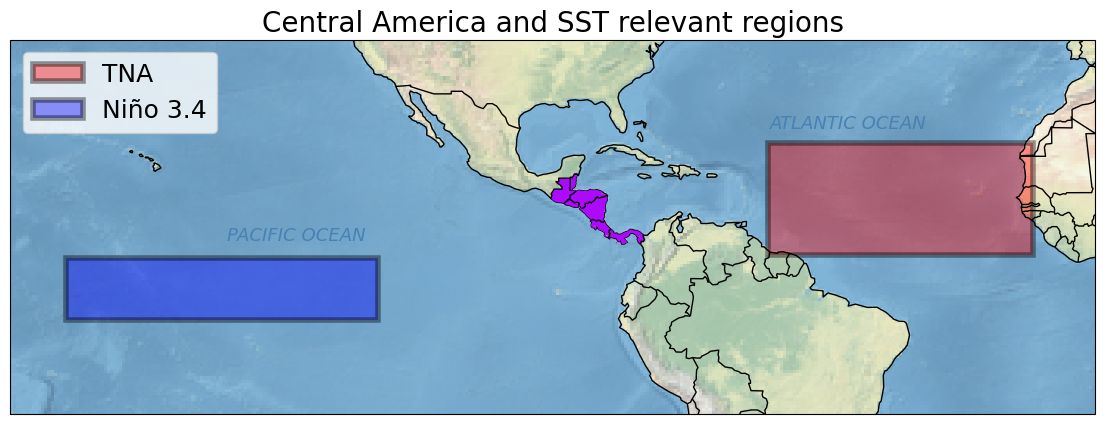

In [5]:
fig = plt.figure( figsize=(14, 6) ) 
ax = plt.axes( projection=ccrs.PlateCarree() ) 

extent = [-179, -5, -20, 40]

ax.stock_img()
ax.coastlines()
ax.set_extent( extent, crs=ccrs.PlateCarree() ) 

#TNA region
tna_ext = [-57.5, -15, 5.5, 23.5 ]
ax.add_patch(   Rectangle( (tna_ext[0], tna_ext[2]),
                            tna_ext[1]-tna_ext[0],
                            tna_ext[3]-tna_ext[2],
                facecolor='red', lw=4.0,
                edgecolor='black', alpha=0.4,
                label='TNA'))


#NINO34 region
nino_ext = [-170, -120, -5, 5 ]
ax.add_patch(   Rectangle( (nino_ext[0], nino_ext[2]),
                            nino_ext[1]-nino_ext[0],
                            nino_ext[3]-nino_ext[2],
                facecolor='blue', lw=4.0,
                edgecolor='black', alpha=0.4, 
                label='Niño 3.4'))

ax.legend(loc='upper left', fontsize=18 )


# Add mask for countries INSIDE Central America
shpfilename = shpreader.natural_earth( resolution='10m',
                                category='cultural',
                                name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
countries_masked = ['GTM', 'SLV', 'BLZ', 'CRI', 'HND', 'PAN', 'NIC' ]

for country in countries:
        if country.attributes['ADM0_A3'] in countries_masked:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                facecolor='xkcd:bright violet',
                                label=country.attributes['ADM0_A3'],
                                zorder=3)
        else:
                continue

ax.add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)

# Label oceans
plt.text( 0.20, 0.50, 'PACIFIC OCEAN', fontsize=13, \
                        transform=ax.transAxes, color='steelblue', \
                        va='top', ha='left', ma='left',\
                        fontstyle='italic', fontvariant='small-caps',\
                        zorder=7)
                        #rotation=10, rotation_mode='anchor_mode')

plt.text( 0.70, 0.80, 'ATLANTIC OCEAN', fontsize=13, \
                        transform=ax.transAxes, color='steelblue', \
                        va='top', ha='left', ma='center',\
                        fontstyle='italic', fontvariant='small-caps',\
                        zorder=7)

ax.set_title( 'Central America and SST relevant regions', fontsize=20  )
plt.savefig('ca-sst-regions.png', dpi=200)

This maps shows **Central America in the purple area.** The **red rectangle represents the Tropical North Atlantic** which influences the generation and development of tropical waves from Africa and the formation of tropical cyclones that affect directly the region. The **blue rectangle limits the area of the region Niño 3.4.** This area is used to defined warm and cold episodes of El Niño-Southern Oscillation. Intense warm episodes of ENSO are associated with severe droughts in the region. 

## Dataset for daily precipitation

Considering that daily precipitation was needed, I use the Global Precipitation Climatology Project (GPCP) dataset, which in its version 3.1 consits of a 0.5-degree (~50 km) grid from june 2000 to december 2019. 

The whole dataset was obtained from:

[GPCP Version 3.1 Daily Precipitation Data Set (GPCPDAY)](https://disc.gsfc.nasa.gov/datasets/GPCPDAY_3.1/summary)

In order to facilitate the access, the data was uploaded to Google Cloud and it is retrieved from there in the following cell. 

In [6]:
import fsspec
fs = fsspec.filesystem('gcs', anon=True)
ncfile_url = 'gs://rces-data/gpcp.nc'
ncfile_file = fs.open(ncfile_url, mode='rb', anon=True)
ds = xr.open_dataset(ncfile_file, engine='h5netcdf', chunks={})
ds

<xarray.Dataset>
Dimensions:  (time: 7153, lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2019-12-31
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(7153, 360, 720), meta=np.ndarray>
Attributes: (12/67)
    ShortName:                      GPCPDAY
    LongName:                       GPCP Precipitation Level 3 Daily 0.5-Degr...
    VersionID:                      3.1
    GranuleID:                      GPCPDAY_L3_20000601_V3.1.nc4
    Format:                         NetCDF-4
    RangeBeginningDate:             2000-06-01
    ...                             ...
    Distribution_Format:            NetCDF-4
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    Fees:                           None
    ProcessingLevel:                Level 3
    institution:                    Mesoscale Atmospheric Processes Laborator...
    comment:                        The GPCP V3.1 Daily is being developed in...

### Reduced original dataset

The dataset is global but I need only the rainfall for Central America, which is a quite narrow region inside the tropics. Also, I need years that are completed, because the start of the rainy season is a yearly characteristic.

In [7]:
sd, ed = '2001-01-01','2019-12-31'
slat, nlat = 6, 19
wlon, elon = -93, -77

In [8]:
ds_small = ds.sel( time=slice(sd,ed), \
                   lon=slice(wlon, elon), \
                   lat=slice(nlat, slat) )
ds_small.precip

<xarray.DataArray 'precip' (time: 6939, lat: 26, lon: 32)>
dask.array<getitem, shape=(6939, 26, 32), dtype=float32, chunksize=(6939, 26, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 18.75 18.25 17.75 17.25 16.75 ... 7.75 7.25 6.75 6.25
  * lon      (lon) float32 -92.75 -92.25 -91.75 -91.25 ... -78.25 -77.75 -77.25
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2019-12-31
Attributes:
    units:         mm/day
    long_name:     precipitation
    valid_range:   [  0. 500.]
    cell_methods:  time: mean
    origname:      precip
    fullnamepath:  /precip

In [9]:
ds = ds_small.load()

### Mean daily rainfall in Central America

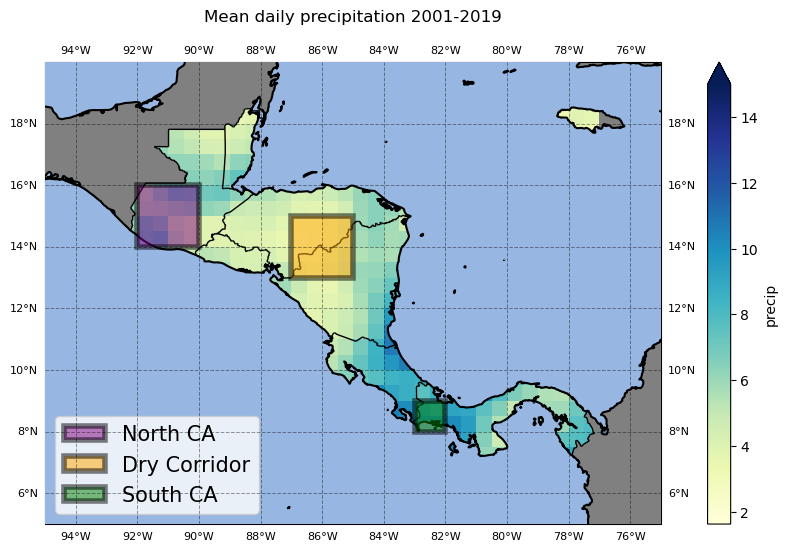

In [24]:
# map extent a bit larger than dataset
extent = [-95,-75, 5, 20]

plt.figure( figsize=(12,6) ) 
ax = plt.axes( projection = ccrs.PlateCarree() ) 
ax.set_extent(extent)

ds.precip.mean(dim='time').plot(ax=ax, cmap='YlGnBu', zorder=3, vmax=15)

ax.set_title('Mean daily precipitation 2001-2019', y=1.07)
ax.add_feature(cfeature.OCEAN, zorder=3)
ax.add_feature(cfeature.LAND, edgecolor='black', color='gray')
ax.add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)
ax.coastlines(linewidth=1.5,zorder=4)

# Add mask for countries outside Central America
shpfilename = shpreader.natural_earth( resolution='10m',
                                category='cultural',
                                name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
countries_masked = ['MEX', 'COL' ]
for country in countries:
        if country.attributes['ADM0_A3'] in countries_masked:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                facecolor='gray',
                                label=country.attributes['ADM0_A3'],
                                zorder=3)
        else:
                continue

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='black', alpha=0.4, 
                  linestyle='--', zorder=7)



#NINO34 region
rdic = {'North CA': [-92, -90, 14, 16 ], 
        'Dry Corridor':[-87,-85, 13, 15], 
        'South CA': [-83,-82, 8, 9]}

colors = ['purple', 'orange', 'green']
i=0

for region in rdic:
    
    ax.add_patch(   Rectangle( (rdic[region][0], rdic[region][2]),
                            rdic[region][1]-rdic[region][0],
                            rdic[region][3]-rdic[region][2],
                facecolor=colors[i], lw=4.0,
                edgecolor='black', alpha=0.5, 
                label=region, zorder=5))
    i+=1

ax.legend(loc='lower left', fontsize=15)

            
lal=np.arange(4,22,2)
lol=np.arange(-94,74,2)
gl.ylocator = mpl.ticker.FixedLocator(lal )
gl.xlocator = mpl.ticker.FixedLocator(lol )


gl.xformatter = cm.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cm.gridliner.LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.savefig('ca_mean-daily-prep_2001-2019.png')

<br/> __Mean daily rainfall in Central America__ for the period of study 2001-2019. The borders of the Central American countries are shown: Belize, Guatemala, El Salvador, Honduras, Nicaragua, Costa Rica and Panama. 

## Onset of the rainy season: Start Date

Tha rainfall data has to be transform to __5-day accumulates (or pentads)__, following the methodology developed in Alfaro (2002). 

The rainy season is established when all of the following happen: 
* A pentad with 25 mm or more rainfall is found.
* At least one of the two succeeding pentads exceeds 25 mm. 
* The two pentads surrouding or following the latter exceed a trace, in this work is 1 mm. 


### Climatology Pentad Rainfall

In [8]:
# The accumulate is from the current date plus the 4 following days. 
rpenday = ds.rolling(time=5, center=-4).sum()
rpenday

<xarray.Dataset>
Dimensions:  (lat: 26, lon: 32, time: 6939)
Coordinates:
  * lat      (lat) float32 18.75 18.25 17.75 17.25 16.75 ... 7.75 7.25 6.75 6.25
  * lon      (lon) float32 -92.75 -92.25 -91.75 -91.25 ... -78.25 -77.75 -77.25
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2019-12-31
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/67)
    ShortName:                      GPCPDAY
    LongName:                       GPCP Precipitation Level 3 Daily 0.5-Degr...
    VersionID:                      3.1
    GranuleID:                      GPCPDAY_L3_20000601_V3.1.nc4
    Format:                         NetCDF-4
    RangeBeginningDate:             2000-06-01
    ...                             ...
    Distribution_Format:            NetCDF-4
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    Fees:                           None
    ProcessingLevel:                Level 3
    institution:                    Mesoscale Atmospheric Processes Laborator...
    comment:                        The GPCP V3.1 Daily is being developed in...

In [9]:
gb = rpenday.precip.groupby( 'time.dayofyear' ) 
rpenday_mean = gb.mean( dim='time' ) 

In [10]:
# pentads without intersection
rpens_clim = rpenday_mean[0:-1:5]
rpens_clim=rpens_clim.to_dataset(name='precip')
rpens_clim

<xarray.Dataset>
Dimensions:    (lat: 26, lon: 32, dayofyear: 73)
Coordinates:
  * lat        (lat) float32 18.75 18.25 17.75 17.25 ... 7.75 7.25 6.75 6.25
  * lon        (lon) float32 -92.75 -92.25 -91.75 ... -78.25 -77.75 -77.25
  * dayofyear  (dayofyear) int64 1 6 11 16 21 26 31 ... 336 341 346 351 356 361
Data variables:
    precip     (dayofyear, lat, lon) float32 26.67 31.02 25.1 ... 82.73 70.81

In [11]:
# Set date format month-day for map 
years=np.arange(2001,2020,1)
pdays=np.arange(1,365,30)
tdates = [ pd.to_datetime(years[0]*1000+day, format='%Y%j') for day in pdays ]
ticdates = [ date.strftime('%m-%d') for date in tdates ]

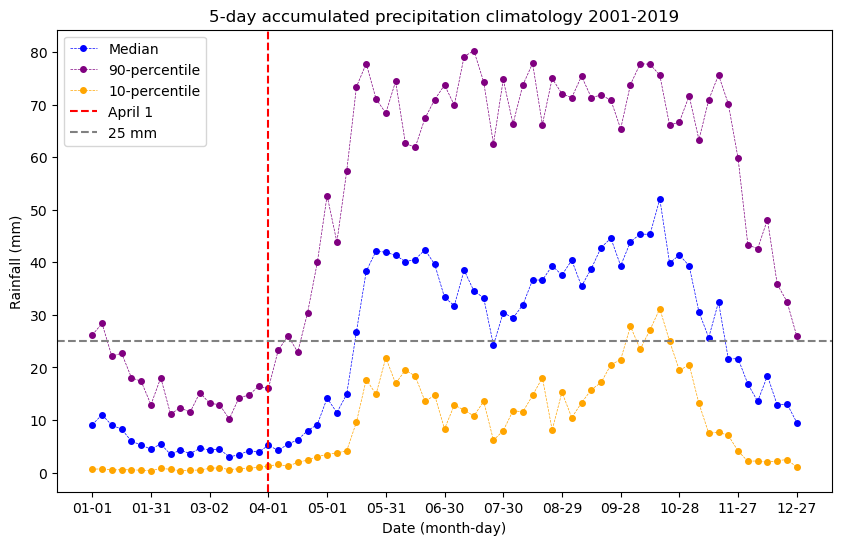

In [12]:
fig, ax = plt.subplots(figsize=(10,6))


rpens_clim.precip.median(dim=('lon','lat')).plot. \
                    line(linestyle='dashed', color='blue',\
                        linewidth=0.5, marker='o', markersize=4,
                        label='Median', ax=ax)

rpens_clim.precip.quantile(q=0.90,dim=('lon','lat') ).plot. \
                    line(linestyle='dashed', color='purple',\
                        linewidth=0.5, marker='o', markersize=4,
                         label='90-percentile', ax=ax)

rpens_clim.precip.quantile(q=0.10,dim=('lon','lat') ).plot. \
                    line(linestyle='dashed', color='orange',\
                        linewidth=0.5, marker='o', markersize=4,
                        label='10-percentile', ax=ax)

ax.set_xticks(pdays)
ax.set_xticklabels(ticdates)
ax.set_xlabel('Date (month-day)' )
ax.set_ylabel('Rainfall (mm)')
plt.axvline( x = 91, color='red', label='April 1', ls='dashed')
plt.axhline( y = 25, color='gray',label='25 mm', ls='dashed')
plt.legend()
plt.title('5-day accumulated precipitation climatology 2001-2019') 

plt.savefig('pentad-clim.png', dpi=300)

From this figure it can be identified that the onset of the rainy season happens after **April 1.** 

### Compute the onset date

The date must fullfil the three aforementioned steps in order to represent the persistance of rainfall related to the rainy season. It has to be computed for every year in 2001-2019 period. 

In [14]:
gb2 = rpenday.groupby('time.year')

In [15]:
arrays  = []

for group_name, group_da in gb2:
    
    ayear=group_name
    rpeny=gb2[ayear].resample(time='5D',label='left').first()
    rpeny=rpeny.sel(time=slice(str(ayear)+'-04-01', str(ayear)+'-10-01' ))
    
    # Evaluate the creteria for onset of rainy season
    pers = ( (rpeny>25) &  ( (rpeny>25).rolling(time=3, center=-2).sum()==2 ) & \
                ( (rpeny>1 ).rolling(time=4, center=-3).sum()==4 ) )
    
    # Get the first date that criteria is fullfil
    vdate= pers.idxmax(dim='time')

    # Transform to day of the year
    vday = vdate.precip.dt.dayofyear
    
    arrays.append(vday)
    
years=np.arange(2001,2020,1)

sdates=xr.concat( arrays, dim='time')

sdates.coords['time'] = years

sdates= sdates.to_dataset(name='sdate')
sdates

<xarray.Dataset>
Dimensions:  (lat: 26, lon: 32, time: 19)
Coordinates:
  * lat      (lat) float32 18.75 18.25 17.75 17.25 16.75 ... 7.75 7.25 6.75 6.25
  * lon      (lon) float32 -92.75 -92.25 -91.75 -91.25 ... -78.25 -77.75 -77.25
  * time     (time) int64 2001 2002 2003 2004 2005 ... 2015 2016 2017 2018 2019
Data variables:
    sdate    (time, lat, lon) int64 221 156 156 151 151 ... 136 121 121 101 111

In [16]:
# mean start date array
sdates_mean = sdates.mean(dim='time')
sdates_mean

<xarray.Dataset>
Dimensions:  (lat: 26, lon: 32)
Coordinates:
  * lat      (lat) float32 18.75 18.25 17.75 17.25 16.75 ... 7.75 7.25 6.75 6.25
  * lon      (lon) float32 -92.75 -92.25 -91.75 -91.25 ... -78.25 -77.75 -77.25
Data variables:
    sdate    (lat, lon) float64 199.7 182.3 174.7 162.8 ... 115.2 112.3 128.6

### Maps with onset date

In [17]:
# Set date format month-day for map 
pdays=np.arange(91,180.1, 15)
tdates = [ pd.to_datetime(years[0]*1000+day, format='%Y%j') for day in pdays ]
ticdates = [ date.strftime('%m-%d') for date in tdates ]

In [18]:
# Colors for map
bounds=pdays
cmapp = plt.cm.get_cmap('RdYlGn_r',len(bounds))
colors = list( cmapp(np.arange(len(bounds))))
colors[0] = 'gray'
cmap = mpl.colors.ListedColormap( colors[:-1],"")
cmap.set_over(colors[-1])
norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)

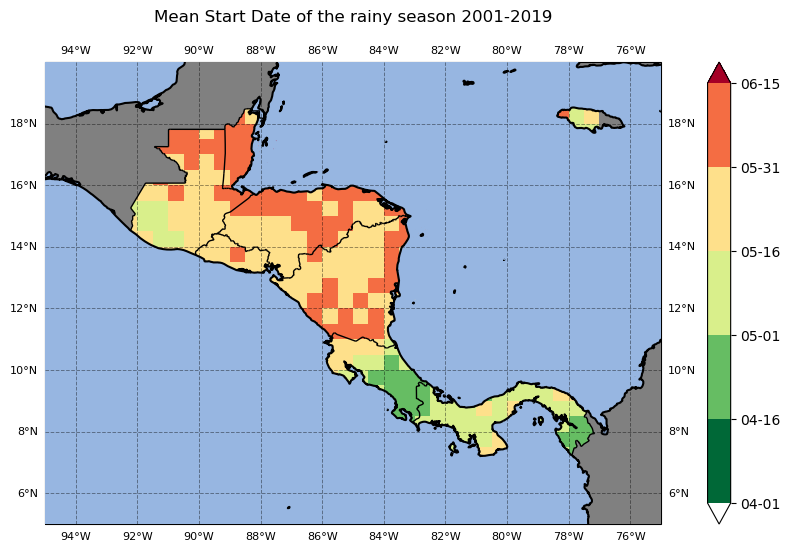

In [19]:
# map extent a bit larger than dataset
extent = [-95,-75, 5, 20]

plt.figure( figsize=(12,6) ) 
ax = plt.axes( projection = ccrs.PlateCarree() ) 
ax.set_extent(extent)

im=sdates_mean.sdate.plot(ax=ax, cmap=cmapp, vmin=pdays[0], vmax=pdays[-1], add_colorbar=False, norm=norm)

ax.set_title('Mean Start Date of the rainy season 2001-2019', y=1.07)
ax.add_feature(cfeature.OCEAN, zorder=3)
ax.add_feature(cfeature.LAND, edgecolor='black', color='gray')
ax.add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)
ax.coastlines(linewidth=1.5,zorder=4)

cbar=plt.colorbar(im, extend='both')
cbar.set_ticks(pdays)
cbar.set_ticklabels(ticdates)


# Add mask for countries outside Central America
shpfilename = shpreader.natural_earth( resolution='10m',
                                category='cultural',
                                name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
countries_masked = ['MEX', 'COL' ]
for country in countries:
        if country.attributes['ADM0_A3'] in countries_masked:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                facecolor='gray',
                                label=country.attributes['ADM0_A3'],
                                zorder=3)
        else:
                continue

# Add gridlines for a map
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='black', alpha=0.4, 
                  linestyle='--', zorder=7)

lal=np.arange(4,22,2)
lol=np.arange(-94,74,2)
gl.ylocator = mpl.ticker.FixedLocator(lal )
gl.xlocator = mpl.ticker.FixedLocator(lol )
gl.xformatter = cm.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cm.gridliner.LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

# Save figure
plt.savefig('ca_mean-star-date_2001-2019.png')
 

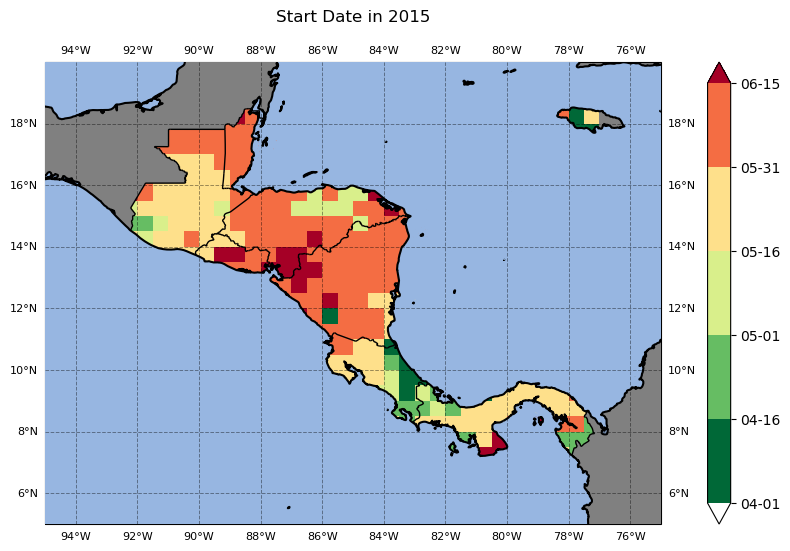

In [20]:
# map extent a bit larger than dataset
oyear=2015
extent = [-95,-75, 5, 20]


plt.figure( figsize=(12,6) ) 
ax = plt.axes( projection = ccrs.PlateCarree() ) 
ax.set_extent(extent)

im=sdates.sdate.sel(time=oyear).plot(ax=ax, cmap=cmapp, vmin=pdays[0], vmax=pdays[-1], add_colorbar=False, norm=norm)

ax.set_title('Start Date in {}'.format(oyear), y=1.07)
ax.add_feature(cfeature.OCEAN, zorder=3)
ax.add_feature(cfeature.LAND, edgecolor='black', color='gray')
ax.add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)
ax.coastlines(linewidth=1.5,zorder=4)

cbar=plt.colorbar(im, extend='both')
cbar.set_ticks(pdays)
cbar.set_ticklabels(ticdates)


# Add mask for countries outside Central America
shpfilename = shpreader.natural_earth( resolution='10m',
                                category='cultural',
                                name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
countries_masked = ['MEX', 'COL' ]
for country in countries:
        if country.attributes['ADM0_A3'] in countries_masked:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                facecolor='gray',
                                label=country.attributes['ADM0_A3'],
                                zorder=3)
        else:
                continue

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='black', alpha=0.4, 
                  linestyle='--', zorder=7)


lal=np.arange(4,22,2)
lol=np.arange(-94,74,2)
gl.ylocator = mpl.ticker.FixedLocator(lal )
gl.xlocator = mpl.ticker.FixedLocator(lol )

gl.xformatter = cm.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cm.gridliner.LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.savefig('ca_star-date_{}.png'.format(oyear))

### Start Date Index (SDI)

The start date can be delayed or anticipated from the normal start date. In order to quantify this, here I compute an standarized anomaly index. 

In [21]:
def stda(x):
    return (x - x.mean(dim='time') ) / x.mean(dim='time') 

In [22]:
anom_sdates = sdates.apply(stda)
anom_sdates

<xarray.Dataset>
Dimensions:  (lat: 26, lon: 32, time: 19)
Coordinates:
  * lat      (lat) float32 18.75 18.25 17.75 17.25 16.75 ... 7.75 7.25 6.75 6.25
  * lon      (lon) float32 -92.75 -92.25 -91.75 -91.25 ... -78.25 -77.75 -77.25
  * time     (time) int64 2001 2002 2003 2004 2005 ... 2015 2016 2017 2018 2019
Data variables:
    sdate    (time, lat, lon) float64 0.1067 -0.1443 -0.107 ... -0.1007 -0.1371

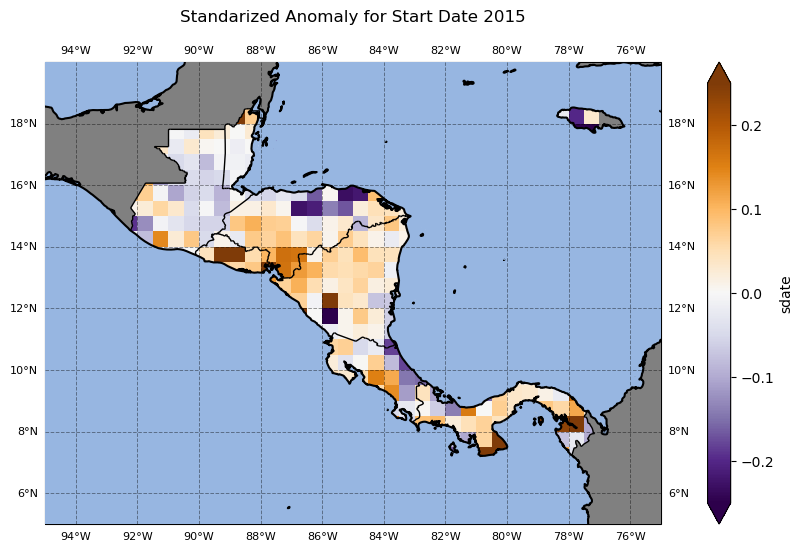

In [23]:
# map extent a bit larger than dataset
ayear = 2015
extent = [-95,-75, 5, 20]
bounds=np.linspace(-0.25,0.25,5)
plt.figure( figsize=(12,6) ) 
ax = plt.axes( projection = ccrs.PlateCarree() ) 
ax.set_extent(extent)

anom_sdates.sdate.sel(time=ayear).plot(ax=ax, cmap='PuOr_r', zorder=3, vmin=bounds[0],vmax=bounds[-1])

ax.set_title('Standarized Anomaly for Start Date {}'.format(ayear), y=1.07)
ax.add_feature(cfeature.OCEAN, zorder=3)
ax.add_feature(cfeature.LAND, edgecolor='black', color='gray')
ax.add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)
ax.coastlines(linewidth=1.5,zorder=4)

# Add mask for countries outside Central America
shpfilename = shpreader.natural_earth( resolution='10m',
                                category='cultural',
                                name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
countries_masked = ['MEX', 'COL' ]
for country in countries:
        if country.attributes['ADM0_A3'] in countries_masked:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                facecolor='gray',
                                label=country.attributes['ADM0_A3'],
                                zorder=3)
        else:
                continue

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='black', alpha=0.4, 
                  linestyle='--', zorder=7)

lal=np.arange(4,22,2)
lol=np.arange(-94,74,2)
gl.ylocator = mpl.ticker.FixedLocator(lal )
gl.xlocator = mpl.ticker.FixedLocator(lol )

gl.xformatter = cm.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cm.gridliner.LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

plt.savefig('ca_stda-start-date_{0}.png'.format(ayear) )

## Sea Surface Temperature Indices

One of the main objectives of this work is to quantify the relation between the start date of rainy season and the interannual variability of sea surface temperature (SST) in the eastern tropical North Atlantic and the central tropical Pacific. 

The __TNA SST anomaly index__ is an indicator of the surface temperatures in the eastern tropical North Atlantic Ocean. It is calculated with monthly averages of SSTs in the box 55°W-15°W, 5°N-25°N. 

The __Niño3.4 SST anomaly index__ is an indicator of central tropical Pacific El Niño conditions. It is calculated with SSTs in the box 170°W-120°W, 5°S-5°N. 

Both indices are calculated here from Reynolds OIv2 SST analysis monthly mean dataset. 

**Seasonal values that are closed to the onset of the rainy season are related to the start date.** In that sense, lets consider the seasonal averages of *February-April*, i.e., a season that preceeds the onset (April-June).

### Niño3.4 SST anomaly index

In [24]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds1 = xr.open_dataset(url, drop_variables=['time_bnds'])
ds1 = ds1.sel(time=slice('1971', '2022')).load()
ds1

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 623)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1971-01-01 1971-02-01 ... 2022-11-01
Data variables:
    sst      (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2022-12-04
    DODS_EXTRA.Unlimited_Dimension:  time

In [28]:
# Compute the index in the box and climatology 1991-2020
gb = ds1.sst.groupby('time.month') 

ds_clim_nino=ds1.sel(time=slice('1991', '2020'))
gbc = ds_clim_nino.sst.groupby('time.month')

ds_anom_nino = gb - gbc.mean(dim='time')
ds_nino = ds_anom_nino.sel( lat=slice(5,-5), lon=slice(360-170, 360-120) ).mean( dim=('lat','lon') ) 

In [29]:
ds_nino.sel(time=slice('2015-01-01','2015-12-31'))
# Three months averages
sea_nino = ds_nino.rolling(time=3, center=True).mean()
# Select the FMA season 
nino34=sea_nino[sea_nino.time.month==3].sel(time=slice('2001', '2019'))
nino34

<xarray.DataArray 'sst' (time: 19)>
array([-0.5327968 , -0.00501391,  0.28585684,  0.13801424,  0.35240787,
       -0.5689146 , -0.1205442 , -1.2883608 , -0.613509  ,  0.8432437 ,
       -0.9234363 , -0.5963515 , -0.3374266 , -0.27853692,  0.53791183,
        1.5949396 ,  0.0519353 , -0.69105023,  0.7239384 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-03-01 2002-03-01 ... 2019-03-01
    month    (time) int64 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

### If ERSST Data is not available: get computed index ONI

In [ ]:
url = 'https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt'
df = pd.read_csv( url, sep=' ', skipinitialspace=True )
df.head()

In [ ]:
url = 'https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt'
df = pd.read_csv( url, sep=' ', skipinitialspace=True )
df.head()

In [ ]:
# Get the season of interest: FMA
df = df[ df.SEAS == 'FMA' ]
df.set_index('YR',inplace=True)
nino34 = df.loc[2001:2019, 'ANOM']
nino34

### TNA SST anomaly index

In [30]:
# Compute the index in the box and climatology 1971-2000
ds_clim_tna=ds1.sel(time=slice('1971', '2000'))
gbc = ds_clim_tna.sst.groupby('time.month')

ds_anom_tna = gb - gbc.mean(dim='time')
ds_tna = ds_anom_tna.sel( lat=slice(23.5 , 5.5), lon=slice(360-57.5, 360-15) ).mean( dim=('lat','lon') ) 
#ds_tna = ds_anom_tna.sel( lat=slice(25 , 5), lon=slice(360-55, 360-15) ).mean( dim=('lat','lon') ) 

In [31]:
sea_tna = ds_tna.rolling(time=3, center=True).mean()
# Select FMA season, month=3
tna=sea_tna[sea_nino.time.month==3].sel(time=slice('2001', '2019'))
tna

<xarray.DataArray 'sst' (time: 19)>
array([ 0.16113082,  0.5471823 , -0.03912906,  0.622821  ,  0.8963446 ,
        0.39449555,  0.6006264 ,  0.43423375, -0.21868321,  1.4504278 ,
        0.6590674 ,  0.03608312,  0.6827301 , -0.13176246,  0.03912481,
        0.58150387,  0.52626   ,  0.00704621,  0.15367854], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-03-01 2002-03-01 ... 2019-03-01
    month    (time) int64 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

### if ERSST is not available: get computed TNA 

In [ ]:
url = 'https://psl.noaa.gov/data/correlation/tna.data'
colname=np.arange(1,13,1)
df = pd.read_csv( url, sep=' ', skipinitialspace=True, skiprows=1, index_col=0, names=colname, skipfooter=2, engine='python')
df.tail()

In [ ]:
df['FMA']=df[ [2,3,4] ].mean(axis=1) 
df['AMJ']=df[ [4,5,6] ].mean(axis=1)
tna=df.loc[2001:2019, 'FMA']
tna

## Relation between start date (SD) and sea surface temperature

In [32]:
# Select a zone in north of CA (Guatemala) and south of CA (Costa Rica-Panama)
norsdat = anom_sdates.sdate.sel( lat=slice(16,14), lon=slice(-92,-90) ).mean( dim=('lat','lon') ) 
sousdat = anom_sdates.sdate.sel( lat=slice(9,8), lon=slice(-83,-82) ).mean( dim=('lat','lon') )
drcsdat = anom_sdates.sdate.sel( lat=slice(15,13), lon=slice(-87,-85) ).mean( dim=('lat','lon') )

In [33]:
data = { 'N-SDATE':norsdat, 'D-SDATE':drcsdat, 'S-SDATE':sousdat,  'TNA':tna, 'NINO34':nino34 }

adf = pd.DataFrame( data,  index=np.arange(2001,2020,1) )
adf.tail()

,N-SDATE,D-SDATE,S-SDATE,TNA,NINO34
2015,-0.004969,0.050686,0.031308,0.039125,0.537912
2016,0.068036,0.035504,-0.060131,0.581504,1.594940
2017,-0.100697,-0.069135,-0.050558,0.526260,0.051935
2018,-0.062850,-0.062155,-0.140239,0.007046,-0.691050
2019,0.117125,0.069304,0.397059,0.153679,0.723938


In [34]:
# Colors for warm, neutral and cold
warm, neutral, cold = 'red', 'gray', 'blue'
lwarm, lcold = 0.5, -0.5
cyears=np.arange(2001,2020,1)

def barcolors(data):
    colors =[]
    for year in cyears:
        if data[year]<lcold:
            colors.append(cold)
        elif data[year]>lwarm:
            colors.append(warm)
        else:
            colors.append(neutral)
    return colors

Text(0.5, 1.0, 'SST Indices for Atlantic and Pacific Oceans')

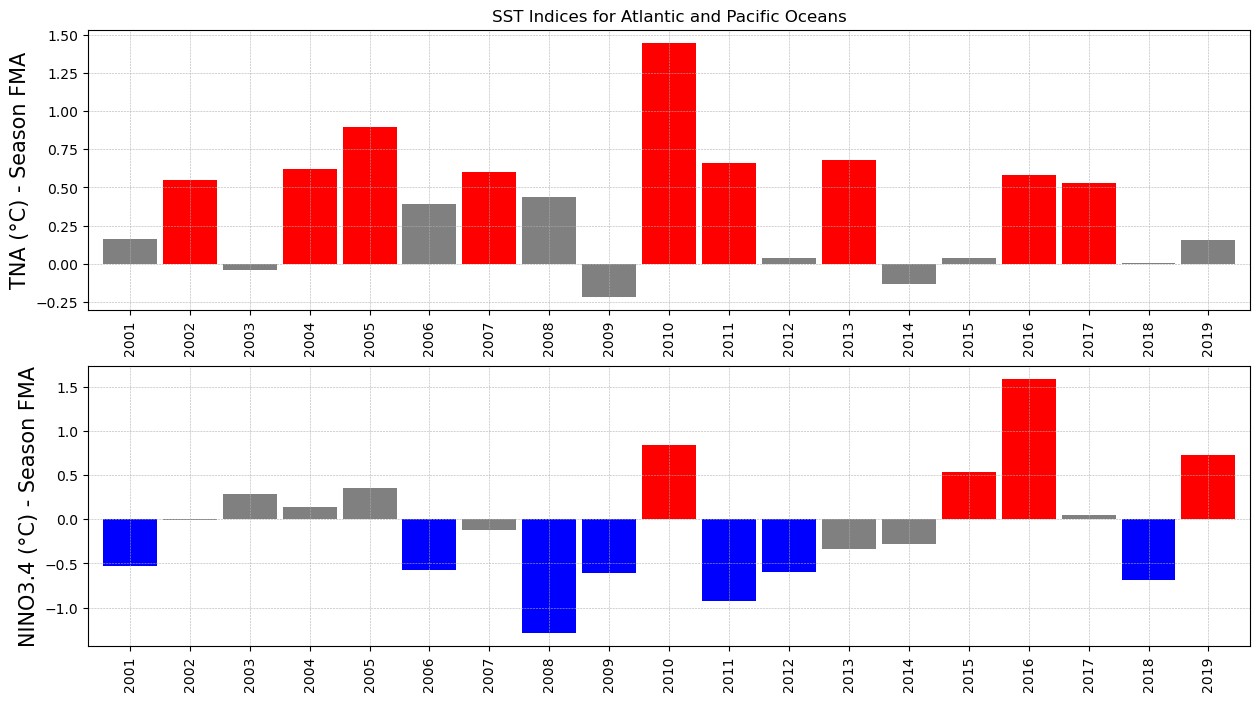

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,8))


adf.plot.bar(y='TNA',ax=ax1, color=barcolors(adf['TNA']), width=0.90, legend=False)
adf.plot.bar(y='NINO34', ax=ax2, color=barcolors(adf['NINO34']), width=0.90, legend=False)
ax1.grid(ls='--', lw=0.4)
ax2.grid(ls='--', lw=0.4)
ax1.set_ylabel('TNA (°C) - Season FMA', fontsize=15)
ax2.set_ylabel('NINO3.4 (°C) - Season FMA', fontsize=15)
ax1.set_title('SST Indices for Atlantic and Pacific Oceans' )

From this time series plot, it can be highlighted there certain years with anomalous warming in the Atlantic and in the Pacific.

__Here I select the years 2015 and 2016 to see the effects on the start date of the rainy season caused by El Niño intense event__. 

__For the Atlantic, I can identified warm seasons in the years in 2005 and 2010__.


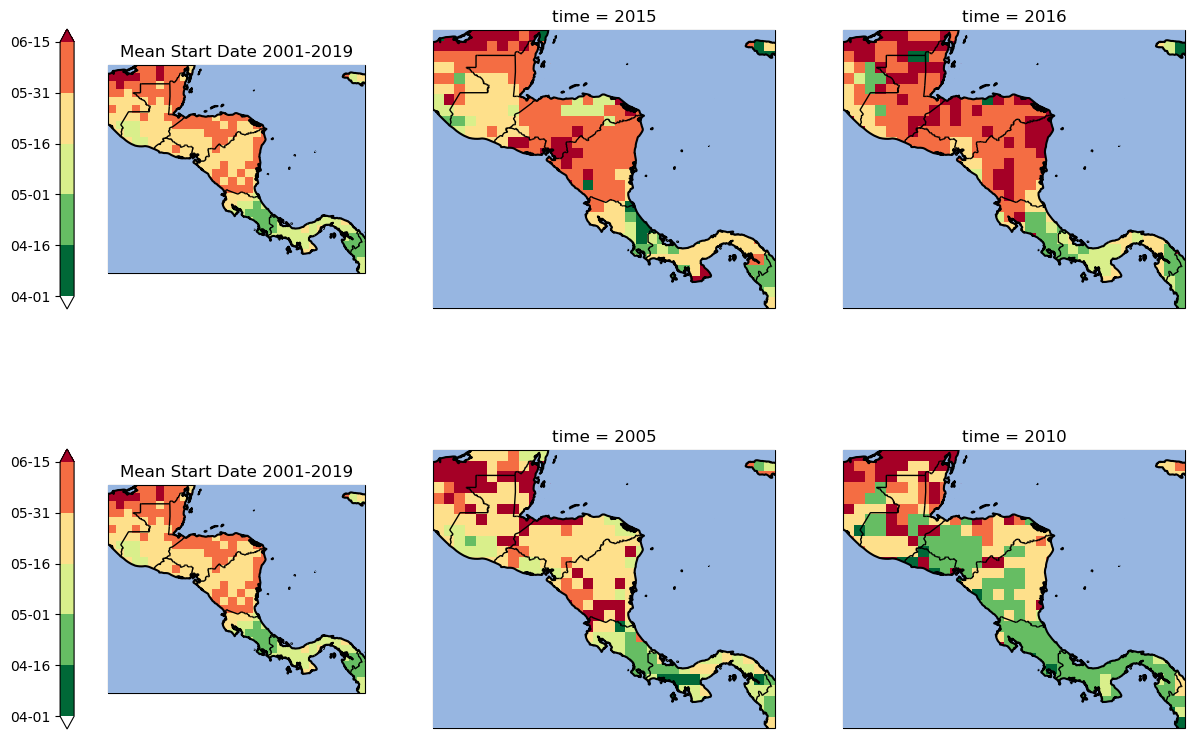

In [37]:
# plot to compare mean start date with intense ENSO warming and cooling
fig, axs = plt.subplots( nrows=2, ncols=3,
                       subplot_kw={'projection':ccrs.PlateCarree()},
                       figsize=(15,10) )
axs=axs.flatten()
syears = ['Mean', 2015, 2016, 2013, 2005, 2010]

for i,year in enumerate(syears):
    
    if i==0 or i==3:
        data = sdates_mean.sdate
        im=data.plot(ax=axs[i], cmap=cmapp, vmin=pdays[0], vmax=pdays[-1], add_colorbar=False, norm=norm)
        axs[i].add_feature(cfeature.OCEAN, zorder=3)
        axs[i].add_feature(cfeature.LAND, edgecolor='black', color='gray')
        axs[i].add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)
        axs[i].coastlines(linewidth=1.5,zorder=4)
        axs[i].set_title('Mean Start Date 2001-2019')
        cbar=plt.colorbar(im, extend='both', location='left', shrink=0.8)
        cbar.set_ticks(pdays)
        cbar.set_ticklabels(ticdates)
    
    else:
        data = sdates.sdate.sel(time=year)
        im=data.plot(ax=axs[i], cmap=cmapp, vmin=pdays[0], vmax=pdays[-1], add_colorbar=False, norm=norm)
        axs[i].add_feature(cfeature.OCEAN, zorder=3)
        axs[i].add_feature(cfeature.LAND, edgecolor='black', color='gray')
        axs[i].add_feature(cfeature.BORDERS, edgecolor='black', zorder=4)
        axs[i].coastlines(linewidth=1.5,zorder=4)

    #im=sdates.sdate.sel(time=year)
    #im=plot(ax=ax, cmap=cmapp, vmin=pdays[0], vmax=pdays[-1], add_colorbar=False, norm=norm)

Observing the start date in these mapas the following can be said:

1. For the **intense warming in the Central Ecuatorial Pacific** during El Niño 2015-16 event, the **start dates were delayed around 10-15 days** from the center to the north of Central America.
2. **Above normal temperatures in the Tropical North Atlantic** during 2010, could be associated to **earlier start dates around 10-30 days** across Central America. 

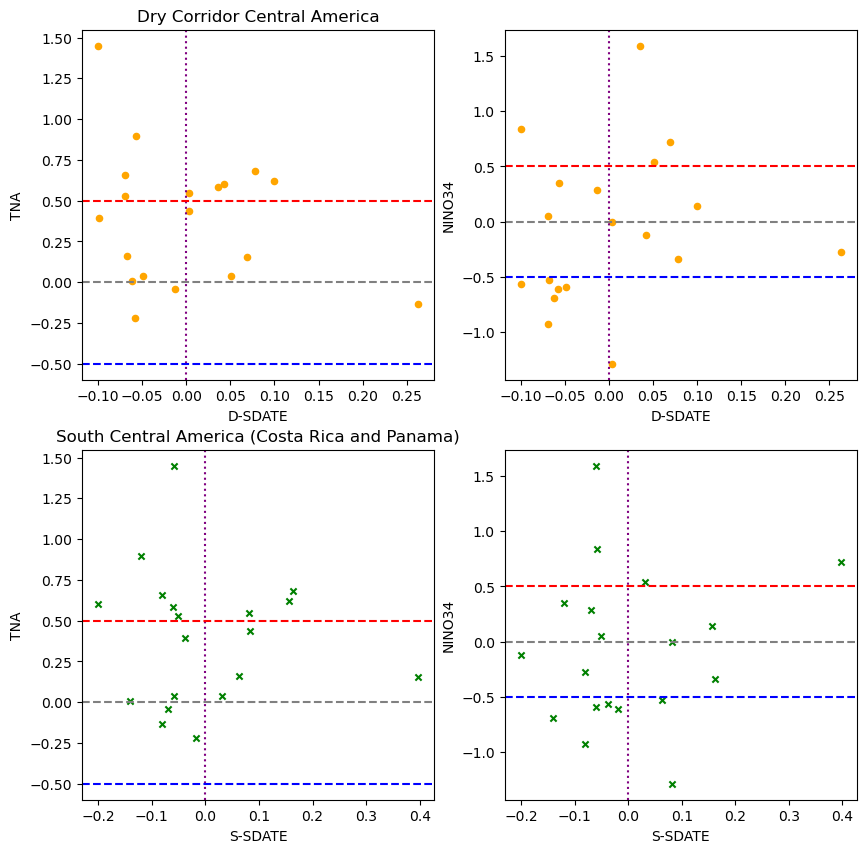

In [38]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axs=axes.flatten()
adf.plot.scatter(x='D-SDATE', y='TNA', ax=axs[0], color='orange')
axs[0].set_title( 'Dry Corridor Central America')
adf.plot.scatter(x='D-SDATE', y='NINO34', ax=axs[1], color='orange')
adf.plot.scatter(x='S-SDATE', y='TNA', ax=axs[2], color='green', marker='x')
axs[2].set_title( 'South Central America (Costa Rica and Panama)')
adf.plot.scatter(x='S-SDATE', y='NINO34', ax=axs[3], color='green', marker='x')

for ax in axs:
    ax.axvline(x=0, color='purple', ls='dotted')
    ax.axhline(y=0.5, color='red', ls='dashed')
    ax.axhline(y=-0.5, color='blue', ls='dashed')
    ax.axhline(y=0, color='gray', ls='dashed')

In [39]:
# Correlation (Pearson)
c1=sps.pearsonr( norsdat, nino34)
c2=sps.pearsonr( sousdat, nino34)
c3=sps.pearsonr( drcsdat, nino34)
cs=[c1,c2,c3]

print('PEARSON-CORR', 'P-VALUE',sep='\t',end='\n\n')
for c in cs: 
    print(round(c.statistic, 3),round(c.pvalue, 3), sep='\t\t')

PEARSON-CORR	P-VALUE

0.305		0.204
0.12		0.623
0.172		0.482


In [40]:
c1=sps.pearsonr( norsdat, tna)
c2=sps.pearsonr( sousdat, tna)
c3=sps.pearsonr( drcsdat, tna)
cs=[c1,c2,c3]

print('PEARSON-CORR', 'P-VALUE',sep='\t', end='\n\n')
for c in cs: 
    print(round(c.statistic,3),round(c.pvalue,3), sep='\t\t')

PEARSON-CORR	P-VALUE

0.119		0.629
-0.066		0.788
-0.265		0.272


### Dataframe with categories for onset of rainy season and warm-cold sst

In [41]:
data = { 'N-SDATE':norsdat, 'S-SDATE':sousdat, 'D-SDATE':drcsdat, 'TNA':tna, 'NINO34':nino34 }

adf = pd.DataFrame( data,  index=np.arange(2001,2020,1) )

In [42]:
adf['N-SCAT'] = 'EARLY'
adf.loc[ adf['N-SDATE'] > 0, 'N-SCAT'] = 'LATE'

adf['S-SCAT'] = 'EARLY'
adf.loc[ adf['S-SDATE'] > 0, 'S-SCAT'] = 'LATE'

adf['D-SCAT'] = 'EARLY'
adf.loc[ adf['D-SDATE'] > 0, 'D-SCAT'] = 'LATE'

# TNA
conditions = [ (adf['TNA']< 0.0),
              (adf['TNA']>0.0) ]

values = ['COLD', 'WARM']


adf['CAT-TNA'] = np.select( conditions, values)


# NINO3.4
conditions = [ (adf['NINO34']< -0.5 ),
              (adf['NINO34']>= -0.5) & (adf['NINO34']<= 0.5),
              (adf['NINO34']>0.5) ]

values = ['COLD', 'NEUTRAL', 'WARM' ]

adf['CAT-NINO34'] = np.select( conditions, values)

adfshow = adf.iloc[:, 5:]
adfshow.tail()

,N-SCAT,S-SCAT,D-SCAT,CAT-TNA,CAT-NINO34
2015,EARLY,LATE,LATE,WARM,WARM
2016,LATE,EARLY,LATE,WARM,WARM
2017,EARLY,EARLY,EARLY,WARM,NEUTRAL
2018,EARLY,EARLY,EARLY,WARM,COLD
2019,LATE,LATE,LATE,WARM,WARM


In [43]:
def _color_early_late(val):
    if val=='LATE':
        color = 'orange'
    elif val=='EARLY': 
        color='green' 
    else: 
        color=None
    return 'color: %s' % color

def _color_cold_warm(val):
    if val=='COLD':
        color = 'blue'
    elif val=='WARM': 
        color='red' 
    else: 
        color=None
    return 'color: %s' % color

adfshow.rename( columns={'N-SCAT':'North CA', 'S-SCAT':'South CA', 'D-SCAT':'CA Dry Corridor', 'CAT-TNA':'Atlantic', 'CAT-NINO34':'Pacific'},inplace=True)
ndf=adfshow.style.applymap(_color_early_late)
ndf.applymap(_color_cold_warm)


,North CA,South CA,CA Dry Corridor,Atlantic,Pacific
2001,LATE,LATE,EARLY,WARM,COLD
2002,LATE,LATE,LATE,WARM,NEUTRAL
2003,LATE,EARLY,EARLY,COLD,NEUTRAL
2004,LATE,LATE,LATE,WARM,NEUTRAL
2005,EARLY,EARLY,EARLY,WARM,NEUTRAL
2006,EARLY,EARLY,EARLY,WARM,COLD
2007,EARLY,EARLY,LATE,WARM,NEUTRAL
2008,LATE,LATE,LATE,WARM,COLD
2009,EARLY,EARLY,EARLY,COLD,COLD
2010,LATE,EARLY,EARLY,WARM,WARM


### What happens when the Pacific is WARM?

In [45]:
Pstate='WARM'

ddf=adfshow[ (adfshow['Pacific']==Pstate) ]
ndf=ddf.style.applymap(_color_early_late)
ndf.applymap(_color_cold_warm)
ndf.set_caption("Onset of Rainy Season when Pacific is {0}".format(Pstate))


,North CA,South CA,CA Dry Corridor,Atlantic,Pacific
2010,LATE,EARLY,EARLY,WARM,WARM
2015,EARLY,LATE,LATE,WARM,WARM
2016,LATE,EARLY,LATE,WARM,WARM
2019,LATE,LATE,LATE,WARM,WARM


### What happens when the Atlantic is WARM but not the Pacific?

In [46]:
Astate='WARM'
Pstate='WARM'
ddf=adfshow[ (adfshow['Atlantic']==Astate) & (adfshow['Pacific']!=Pstate) ]
ndf=ddf.style.applymap(_color_early_late)
ndf.applymap(_color_cold_warm)
ndf.set_caption("Onset of Rainy Season when Atlantic is {0}".format(Astate))


,North CA,South CA,CA Dry Corridor,Atlantic,Pacific
2001,LATE,LATE,EARLY,WARM,COLD
2002,LATE,LATE,LATE,WARM,NEUTRAL
2004,LATE,LATE,LATE,WARM,NEUTRAL
2005,EARLY,EARLY,EARLY,WARM,NEUTRAL
2006,EARLY,EARLY,EARLY,WARM,COLD
2007,EARLY,EARLY,LATE,WARM,NEUTRAL
2008,LATE,LATE,LATE,WARM,COLD
2011,LATE,EARLY,EARLY,WARM,COLD
2012,LATE,EARLY,EARLY,WARM,COLD
2013,EARLY,LATE,LATE,WARM,NEUTRAL
